In [1]:
import pm4py
import pandas

#dataPath = "E:\Data\DOI-10-13012-b2idb-0647142_v3\PhoenixBLN-NYT_1980-2018.csv"
dataPath = "/media/sasha/HDD-bigboy/Data/DOI-10-13012-b2idb-0647142_v3/PhoenixBLN-NYT_1980-2018.csv"

In [2]:
def code2text_Pheonix(event_log):
    #translatets root_codes for pheonix data
    translationMap = {"1":"Make Public Statement", "2":"Appeal", "3":"Express intent to cooperate",
                    "4":"Consult", "5":"Engage in diplomatic cooperation","6":"Engage in material cooperation",
                    "7":"Provide aid", "8":"Yield", "9":"Investigate", 
                    "10":"Demand", "11":"Disapprove", "12":"Reject", 
                    "13":"Threaten", "14":"Protest", "15":"Exhibit force posture", 
                    "16":"Reduce relations", "17":"Coerce", "18":"Assault",
                    "19":"Fight","20":"Use unconventional mass violence"}
    def translate(x):
        return translationMap[str(x)]
    event_log['root_code_text'] = event_log['root_code'].apply(translate)    
    return event_log

def preprocess(event_log, key="empty", remove_activity_keys=[]):
    #remove activities
    if len(remove_activity_keys) > 0:
        for code_key in remove_activity_keys:
            event_log = event_log[event_log.root_code != code_key]
            print(event_log["root_code"])
            
    #extract root country
    event_log["source_root"] = event_log["source"].apply(lambda x : x[0:3])
    event_log["target_root"] = event_log["target"].apply(lambda x : x[0:3])
    #create conflict_id
    event_log["conflict_id"] = event_log["source_root"] + event_log["target_root"]
    #select conflict
    if key != "empty":
        event_log = event_log[event_log.conflict_id == key]
    #event_log = event_log[event_log.source == "DDR"]
    #decode codes
    event_log = code2text_Pheonix(event_log)
    
    #format to pm4py
    event_log = pm4py.format_dataframe(event_log, case_id='conflict_id', activity_key='root_code_text', timestamp_key='story_date')
    start_activities = pm4py.get_start_activities(event_log)
    end_activities = pm4py.get_end_activities(event_log)
    print("Start activities: {}\nEnd activities: {}".format(start_activities, end_activities))
    return event_log

def import_csv(file_path):
    event_log = pandas.read_csv(file_path, sep=',')
    return event_log 

In [27]:

def normalize_dfg(dfg):
    #normalize the edges to sum to 1

    absolut_weight = 0
    for (source, target), weight in dfg.items():
        absolut_weight += weight
    # normalize the weight of transitions into each target node
    for (source, target), weight in dfg.items():
        dfg[(source, target)] = weight / absolut_weight

    return dfg

def target_normalize_dfg(dfg):
    #normalize the edges to each target node to sum to 1
    #note im using the origional dfg here so when we max_path_denoise
    #so we can see how much percent of the incoming transitions each transition represents

    # create a dictionary to store the total weight of transitions into each target node
    total_weight = {}
    for (source, target), weight in dfg.items():
        if target in total_weight:
            total_weight[target] += weight
        else:
            total_weight[target] = weight

    # normalize the weight of transitions into each target node
    for (source, target), weight in dfg.items():
        dfg[(source, target)] = weight / total_weight[target]

    return dfg

def source_normalize_dfg(dfg):
    #normalize the edges to each source node to sum to 1
    #note im using the origional dfg here so when we max_path_denoise
    #so we can see how much percent of the incoming transitions each transition represents

    # create a dictionary to store the total weight of transitions into each source node
    total_weight = {}
    for (source, target), weight in dfg.items():
        if source in total_weight:
            total_weight[source] += weight
        else:
            total_weight[source] = weight

    # normalize the weight of transitions into each source node
    for (source, target), weight in dfg.items():
        dfg[(source, target)] = weight / total_weight[source]

    return dfg


def get_eventually_follows_in_days_graph(event_log, daysFollow):
    
    ret_dict = {}
    from enum import Enum
    from pm4py.objects.conversion.log import converter
    from pm4py.objects.log.util import sorting

    from pm4py.util import exec_utils, xes_constants, constants

    class Parameters(Enum):
        ACTIVITY_KEY = constants.PARAMETER_CONSTANT_ACTIVITY_KEY
        TIMESTAMP_KEY = constants.PARAMETER_CONSTANT_TIMESTAMP_KEY
        START_TIMESTAMP_KEY = constants.PARAMETER_CONSTANT_START_TIMESTAMP_KEY
        KEEP_FIRST_FOLLOWING = "keep_first_following"

    parameters = {}
    event_log = converter.apply(event_log, variant=converter.Variants.TO_EVENT_LOG, parameters=parameters)

    activity_key = exec_utils.get_param_value(Parameters.ACTIVITY_KEY, parameters, xes_constants.DEFAULT_NAME_KEY)
    timestamp_key = exec_utils.get_param_value(Parameters.TIMESTAMP_KEY, parameters,
                                            xes_constants.DEFAULT_TIMESTAMP_KEY)
    start_timestamp_key = exec_utils.get_param_value(Parameters.START_TIMESTAMP_KEY, parameters,
                                                    xes_constants.DEFAULT_TIMESTAMP_KEY)
    keep_first_following = exec_utils.get_param_value(Parameters.KEEP_FIRST_FOLLOWING, parameters, False)
    time_threshold = pandas.Timedelta(days=daysFollow)

    for trace in event_log:
        sorted_trace = sorting.sort_timestamp_trace(trace, start_timestamp_key)
        i = 0
        while i < len(sorted_trace):
            act1 = sorted_trace[i][activity_key]
            tc1 = sorted_trace[i][timestamp_key]
            j = i + 1
            while j < len(sorted_trace):
                ts2 = sorted_trace[j][start_timestamp_key]
                act2 = sorted_trace[j][activity_key]
                if ts2 - tc1 <= time_threshold and ts2 >= tc1:
                    tup = (act1, act2)
                    if tup not in ret_dict:
                        ret_dict[tup] = 0
                    ret_dict[tup] += 1
                    if keep_first_following:
                        break
                j += 1
            i += 1
    return ret_dict

In [42]:
def make_process_tree(event_log, show=True):
    process_tree = pm4py.discover_process_tree_inductive(event_log)
    bpmn_model = pm4py.convert_to_bpmn(process_tree)
    if(show):
        pm4py.view_bpmn(bpmn_model)
    return process_tree

def make_dfg(event_log, minThresh = 1,
            max_path_denoise=False,
            show=True, scale =False, 
            eventualyFollow = False, 
            daysFollow=100,
            normalize = False, normalize_to = "target"):
    
    
    
    dfg, start_activities, end_activities = pm4py.discover_dfg(event_log, case_id_key='case:concept:name', activity_key='concept:name', timestamp_key='time:timestamp')
    
    if eventualyFollow:
        dfg = get_eventually_follows_in_days_graph(event_log, daysFollow)
    
    preDenoise = dfg.copy()



    if normalize:
        if normalize_to == "target":
            dfg = target_normalize_dfg(dfg)
        elif normalize_to == "source":
            dfg = source_normalize_dfg(dfg)
        l = 0
        for val in preDenoise.values():
            l += val            
        for key in dfg.keys():
            dfg[key] *= l

    if max_path_denoise:
        dfg = {activities: value for activities, value in dfg.items() 
               if activities[0] != activities[1] and 
               (value >= max([x for k,x in dfg.items() if k[0] == activities[0]])
                                                                                                            or value >= max([x for k,x in dfg.items() if k[1] == activities[1]]))}      

    if scale:
        l = 0
        for val in preDenoise.values():
            l += val
        for key in dfg.keys():
            dfg[key] *= (1/l)

    dfg = {activities: value for activities, value in dfg.items() if value >= minThresh}

    if show:
        pm4py.view_dfg(dfg, start_activities=None, end_activities=None, format='png')
    return dfg

def make_petrinet(event_log, show=True):
    #no clue what markings are but this should get us a petrinet
    #network, iMarking, fMarking = pm4py.discovery.discover_petri_net_alpha(event_log)
    #network, iMarking, fMarking = pm4py.discover_petri_net_inductive(event_log,noise_threshold = 0.7)
    network, iMarking, fMarking = pm4py.discover_petri_net_heuristics(event_log)
    if show:
        pm4py.view_petri_net(network, iMarking, fMarking)
    return network, iMarking, fMarking
def make_bpmn(event_log, show=True):
    efg = pm4py.discover_bpmn_inductive(event_log, noise_threshold = 0.7, multi_processing=True)
    if show:
        pm4py.view_bpmn(efg)
    return efg

Start activities: {'Engage in material cooperation': 1}
End activities: {'Fight': 1}


/tmp/ipykernel_10878/3279225646.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  event_log['root_code_text'] = event_log['root_code'].apply(translate)
/home/sasha/.local/lib/python3.10/site-packages/pm4py/utils.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[constants.CASE_CONCEPT_NAME] = df[case_id]
/home/sasha/.local/lib/python3.10/site-packages/pm4py/utils.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

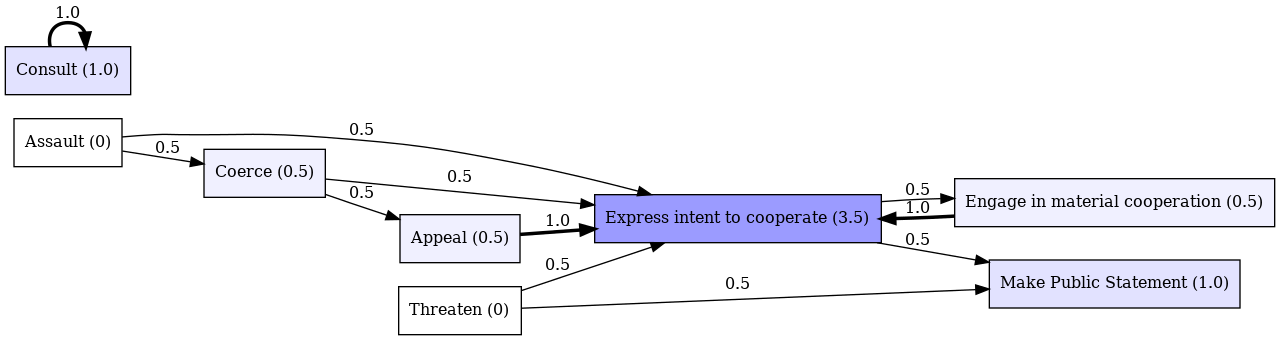

{('Threaten', 'Express intent to cooperate'): 0.5, ('Threaten', 'Make Public Statement'): 0.5, ('Express intent to cooperate', 'Make Public Statement'): 0.5, ('Assault', 'Coerce'): 0.5, ('Consult', 'Consult'): 1.0, ('Assault', 'Express intent to cooperate'): 0.5, ('Coerce', 'Appeal'): 0.5, ('Coerce', 'Express intent to cooperate'): 0.5, ('Appeal', 'Express intent to cooperate'): 1.0, ('Express intent to cooperate', 'Engage in material cooperation'): 0.5, ('Engage in material cooperation', 'Express intent to cooperate'): 1.0}


In [53]:
#selector block, config and select stuff here

event_log = import_csv(dataPath)
event_log_r = preprocess(event_log,key="DDRUSA")

dfg = make_dfg(event_log_r, scale=True,
            max_path_denoise=False, minThresh=0.2, show=True, 
            eventualyFollow=True, daysFollow=22, normalize=True, normalize_to="source")
print(dfg)
#make_dfg(event_log_r,minThresh =4)
#make_bpmn(event_log)
#make_process_tree(event_log)
#make_petrinet(event_log)